In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [285]:
rho = 5
alpha = 0.3

z_grid = np.arange(-25, 25)
phis = rho * np.sqrt(np.pi) * alpha * np.exp(- (np.pi * alpha * z_grid)**2)
lambs = phis / (1 - phis)


def gaussian_dens_kernel(x, y):
    tmp =  x[:, np.newaxis] - y[np.newaxis, :]
    dotprod = np.einsum('i,jk->ijk', z_grid, tmp)
    out = np.sum(np.cos(2 * np.pi * dotprod) * lambs[:, np.newaxis, np.newaxis], axis=0)
    return out


def conditional_gaussian_dens_kernel(x, y, ystar):
    A = gaussian_dens_kernel(x, y)
    B = gaussian_dens_kernel(x, ystar)
    C = gaussian_dens_kernel(ystar, ystar)
    D = gaussian_dens_kernel(ystar, y)
    return A - B @ np.linalg.inv(C) @ D


def gaussian_mom_kernel(x, y):
    tmp =  x[:, np.newaxis] - y[np.newaxis, :]
    return rho * np.exp(- (tmp / alpha)**2)


def gaussian_mom_dens(x):
    return np.linalg.det(gaussian_mom_kernel(x, x))


def conditional_gaussiam_mom_kernel(x, y, ystar):
    A = gaussian_mom_kernel(x, y)
    B = gaussian_mom_kernel(x, ystar)
    C = gaussian_mom_kernel(ystar, ystar)
    D = gaussian_mom_kernel(ystar, y)
    return A - B @ np.linalg.inv(C) @ D


def get_conditional_eigvals(ystar):
    x = np.linspace(-0.5, 0.5, 500)
    #out1 = np.linalg.eigh(conditional_gaussian_dens_kernel(x, x, ystar))[0] * (x[1] - x[0])
    #out = np.clip(out1, a_min=0, a_max=np.inf)
    #out = out / (1 + out)
    out = np.linalg.eigh(conditional_gaussiam_mom_kernel(x, x, ystar))[0] * (x[1] - x[0])
    out = np.clip(out, 0, 1)
    return out[-len(phis):]


def get_bernoulli_sum_pmf(pvals, nsim=50000):
    vals = np.array([np.random.binomial(1, p, nsim) for p in pvals])
    vals = np.sum(vals, axis=0)
    cnts = np.array([np.sum(vals == i) for i in range(len(pvals))])
    return cnts / nsim


def marginal_dpp_dist(ystar, alpha, ndata):
    k = len(ystar)
    pvals = get_conditional_eigvals(ystar)
    qr = get_bernoulli_sum_pmf(pvals)
    tmp = qr * gamma(k + np.arange(len(qr)) * alpha) / \
        gamma(k + np.arange(len(qr)) * alpha + ndata)
    out = np.sum(tmp) * gaussian_mom_dens(ystar)
    return out


def marginal_pois_dist(ystar, alpha, rho, ndata):
    k = len(ystar)
    qr = tfd.Poisson(rho).prob(np.arange(30))
    tmp = qr * gamma((k + np.arange(len(qr))) * alpha) / \
        gamma((k + np.arange(len(qr))) * alpha + ndata)
    out = np.sum(tmp) * rho ** 2
    return out

In [296]:
dpp_out = []
pois_out = []
dist = np.linspace(0.001, 0.2, 10)

for d in dist:
    ystar = np.array([-d, d])
    dpp_out.append(marginal_dpp_dist(ystar, 1.0, 5))
    pois_out.append(marginal_pois_dist(ystar, 1.0, 1.0, 5))   
    
dpp_out = np.array(dpp_out)
pois_out = np.array(pois_out)

In [323]:
dpp_out2 = []
dist = np.linspace(0.001, 0.2, 10)
for d in dist:
    ystar = np.array([-0.3, - 0.3 + 2 * d])
    dpp_out2.append(marginal_dpp_dist(ystar, 1.0, 5))

dpp_out2 = np.array(dpp_out2)

In [324]:
dpp_out3 = []
dist = np.linspace(0.001, 0.2, 10)
for d in dist:
    ystar = np.array([-d, 0, d])
    dpp_out3.append(marginal_dpp_dist(ystar, 1.0, 5))

dpp_out3 = np.array(dpp_out3)

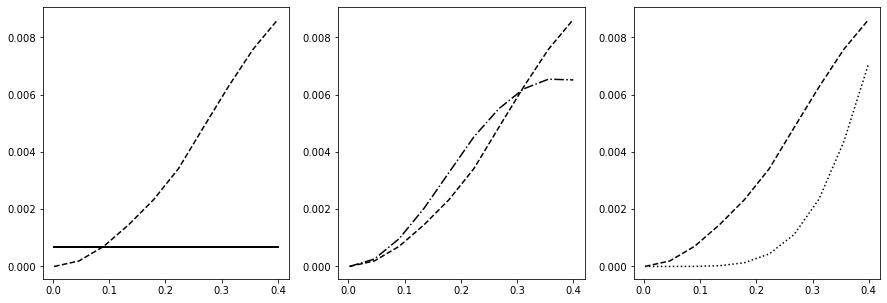

In [326]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].plot(2 * dist, pois_out, linestyle="-", color="black", linewidth=2, label="Poi")
axes[0].plot(2 * dist, dpp_out, linestyle="--", color="black", label="DPP")

axes[1].plot(2*dist, dpp_out, linestyle="--", color="black", label="DPP")
axes[1].plot(2*dist, dpp_out2, linestyle="-.", color="black", label="DPP")

axes[2].plot(2*dist, dpp_out, linestyle="--", color="black", label="DPP")
axes[2].plot(2*dist, dpp_out3, linestyle=":", color="black", label="DPP")
plt.savefig("dpp_vs_pois.pdf", bbox_inches="tight")

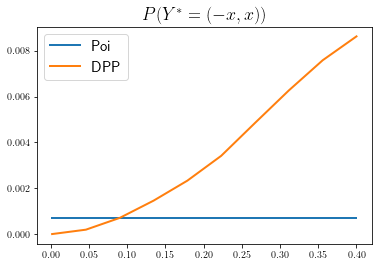

In [343]:
plt.rcParams.update({
  "text.usetex": True})

plt.plot(2 * dist, pois_out, linewidth=2, label="Poi")
plt.plot(2 * dist, dpp_out, linewidth=2, label="DPP")
plt.title("$P(Y^* = (-x, x))$", fontsize=18)
plt.legend(fontsize=15)
plt.savefig("dpp_poi1.pdf", bbox_inches="tight")

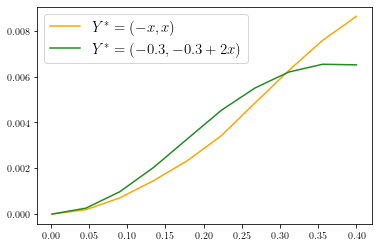

In [346]:
plt.plot(2*dist, dpp_out, color="orange", label="$Y^* = (-x, x)$")
plt.plot(2*dist, dpp_out2, color="forestgreen", label="$Y^* = (-0.3, -0.3 + 2x)$")
plt.legend(fontsize=15)
plt.savefig("dpp_poi2.pdf", bbox_inches="tight")

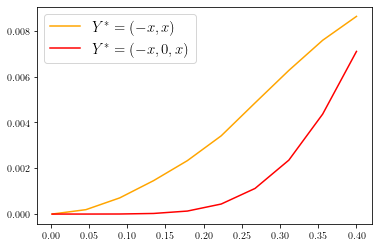

In [349]:
plt.plot(2*dist, dpp_out, color="orange", label="$Y^* = (-x, x)$")
plt.plot(2*dist, dpp_out3, color="red", label="$Y^* = (-x, 0, x)$")
plt.legend(fontsize=15)
plt.savefig("dpp_poi3.pdf", bbox_inches="tight")